## About

Wokring with data provided by solar panels. Data comes  from [Solar Measurement Grid (1.5-Year Archive) 1-Second Global Horizontal Irradiance Oahu, Hawaii](http://www.nrel.gov/midc/oahu_archive/). It actually measuring not the energy productions, rather then irradiance known as "Global Horizontal Irradiance Grid".

### Dataset Benefits

Current dataset can be used to proved "correctness" (or correlation with reality) of a model that deals with predictions of "irradiance level".    

### Links

* [Solar Measurement Grid (1.5-Year Archive) 1-Second Global Horizontal Irradiance Oahu, Hawaii](http://www.nrel.gov/midc/oahu_archive/)
* [NREL - Oahu Solar Measurement Grid (1-Year Archive): 1-Second Solar Irradiance; Oahu, Hawaii (Data)](https://data.nrel.gov/submissions/11)
* [Oahu Archive Instrument Descriptions and Histories](http://www.nrel.gov/midc/oahu_archive/instruments.html#GH1)
* [Satellite map showing measurement locations](http://www.nrel.gov/midc/oahu_archive/map.jpg)

### Description of Dataset

#### Data Set Information

Seventeen measurement stations in the south western region of the island of Oahu collected data at 1-second intervals over the course of a year. The sensors are located in a 1-kilometer grid and the information then can be used to predict what PV outputs might be at 1-second intervals for medium-sized and large PV systems. This DOE-funded study by NREL supports the Hawaii Clean Energy Initiative (HCEI), a multifaceted program to substantially increase the use of renewable energy in Hawaii.


#### Attribute Information:

* DOY - Day Of The Year

|Field #	|	Instrument	|	Units|
|----------|:-------------:|------:|
|1	|	Seconds	|	ss |
|2	|	Year	|	   |
|3	|	DOY	|	       |
|4	|	HST	|	hhmm   |
|5	|	Global Horizontal DH3 (201)	|	W/m2 |
|6	|	Global Horizontal DH4 (202)	|	W/m2 |
|7	|	Global Horizontal DH5 (203)	|	W/m2 |
|8	|	Global Horizontal DH10 (204)	|	W/m2 |
|9	|	Global Horizontal DH11 (205)	|	W/m2 |
|10	|	Global Horizontal DH9 (206)	|	W/m2 |
|11	|	Global Horizontal DH2 (207)	|	W/m2 |
|12	|	Global Horizontal DH1 (208)	|	W/m2 |
|13	|	Global Tilt DH1 (208)	    |	W/m2 |
|14	|	Global Horizontal AP6 (209)	|	W/m2 |
|15	|	Global Tilt AP6 (209)	    |	W/m2 |
|16	|	Global Horizontal AP1 (210)	|	W/m2 |
|17	|	Global Horizontal AP3 (211)	|	W/m2 |
|18	|	Global Horizontal AP5 (212)	|	W/m2 |
|19	|	Global Horizontal AP4 (213)	|	W/m2 |
|20	|	Global Horizontal AP7 (214)	|	W/m2 |
|21	|	Global Horizontal DH6 (215)	|	W/m2 |
|22	|	Global Horizontal DH7 (216)	|	W/m2 |
|23	|	Global Horizontal DH8 (217)	|	W/m2 |



### Overall Data Analysis Approach

* A. Prelimenary Statistical Analysis
	1. Make charts with probability density estimate in order to see that data are not distributed normally (non-Gaussian).
	2. Make scatter plots with correlations in order to show visually that it's hardly traceable.
	3. Report with tables filled with values that mutual information and correlations coefficients are properly holding.
	4. Create table with matrix showing correlations between input variables (covariance matrix).
* B. Machine Learning
	5. Obtain coefficients for final model within the 100 random tries (via cross-validation's K-fold) to see that they are stable.
	6. For each machine learning method (IRLS, Random Forest) and each measuring method (MAE, MSE, MRE) calculate mean and standard deviation, which then should be averaged over all attempts made (x100).

### Configurations

Importing requred packages. Setting first configuration settings.

In [1]:
# global constants

DATA_FOLDER = 'data'

In [2]:
%matplotlib inline

import os
import glob
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

In [3]:
# global IPython settings

#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
# column names

columns = ['Seconds',
            'Year',
            'DOY',
            'HST',
            'GlobHoriz DH3 (201)',
            'GlobHoriz DH4 (202)',
            'GlobHoriz DH5 (203)',
            'GlobHoriz DH10 (204)',
            'GlobHoriz DH11 (205)',
            'GlobHoriz DH9 (206)',
            'GlobHoriz DH2 (207)',
            'GlobHoriz DH1 (208)',
            'GlobTilt DH1 (208)',
            'GlobHoriz AP6 (209)',
            'GlobTilt AP6 (209)',
            'GlobHoriz AP1 (210)',
            'GlobHoriz AP3 (211)',
            'GlobHoriz AP5 (212)',
            'GlobHoriz AP4 (213)',
            'GlobHoriz AP7 (214)',
            'GlobHoriz DH6 (215)',
            'GlobHoriz DH7 (216)',
            'GlobHoriz DH8 (217)']

target_cols = columns[4:]
single_pv = 'GlobHoriz DH3 (201)'

print ('SOLAR PANELS:\n{0}\n'.format('\n'.join(target_cols)))
print ("TOTAL SOLAR PANELS:\n{0}\n".format(len(target_cols)))
print ("SELECTED SINGLE PANEL:\n{0}\n".format(single_pv))

SOLAR PANELS:
GlobHoriz DH3 (201)
GlobHoriz DH4 (202)
GlobHoriz DH5 (203)
GlobHoriz DH10 (204)
GlobHoriz DH11 (205)
GlobHoriz DH9 (206)
GlobHoriz DH2 (207)
GlobHoriz DH1 (208)
GlobTilt DH1 (208)
GlobHoriz AP6 (209)
GlobTilt AP6 (209)
GlobHoriz AP1 (210)
GlobHoriz AP3 (211)
GlobHoriz AP5 (212)
GlobHoriz AP4 (213)
GlobHoriz AP7 (214)
GlobHoriz DH6 (215)
GlobHoriz DH7 (216)
GlobHoriz DH8 (217)

TOTAL SOLAR PANELS:
19

SELECTED SINGLE PANEL:
GlobHoriz DH3 (201)



## Load and View Data for a Single DAY (all panels)

In [5]:
SINGLE_MONTH = '{0}\{1}'.format(DATA_FOLDER, '201110')    # single month

#SINGLE_DAY = '{0}\{1}'.format(SINGLE_MONTH, '20111001.txt')
SINGLE_DAY = '{0}\{1}'.format(SINGLE_MONTH, '20111002.txt')

dataset = pd.read_csv(SINGLE_DAY, header=None, sep=',')

# set column names from settings
dataset.columns = columns

dataset.head(5)

Seconds  Year  DOY  HST  GlobHoriz DH3 (201)  GlobHoriz DH4 (202)  \
0        0  2011  275  500             0.000000                  0.0   
1        1  2011  275  500             0.000000                  0.0   
2        2  2011  275  500             0.000000                  0.0   
3        3  2011  275  500             0.472082                  0.0   
4        4  2011  275  500             0.000000                  0.0   

   GlobHoriz DH5 (203)  GlobHoriz DH10 (204)  GlobHoriz DH11 (205)  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   

   GlobHoriz DH9 (206)         ...           GlobHoriz AP6 (209)  \
0                  0.0         ...                           0.0   
1                  0.0         ...                           0.0   
2                  0.0         ...                           0.0   
3                  0.0         ...                           0.0   
4                  0.0         ...                           0.0   

   GlobTilt AP6 (209)  GlobHoriz AP1 (210)  GlobHoriz AP3 (211)  \
0                 0.0                  0.0               -99999   
1                 0.0                  0.0               -99999   
2                 0.0                  0.0               -99999   
3                 0.0                  0.0               -99999   
4                 0.0                  0.0               -99999   

   GlobHoriz AP5 (212)  GlobHoriz AP4 (213)  GlobHoriz AP7 (214)  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   GlobHoriz DH6 (215)  GlobHoriz DH7 (216)  GlobHoriz DH8 (217)  
0                  0.0                  0.0                  0.0  
1                  0.0                  0.0                  0.0  
2                  0.0                  0.0                  0.0  
3                  0.0                  0.0                  0.0  
4                  0.0                  0.0                  0.0  

[5 rows x 23 columns]

In [6]:
# Data Description

dataset.describe()

Seconds     Year      DOY           HST  GlobHoriz DH3 (201)  \
count  54001.000000  54001.0  54001.0  54001.000000         54001.000000   
mean      29.499454   2011.0    275.0   1229.514268           428.107069   
std       17.318568      0.0      0.0    432.409039           385.242518   
min        0.000000   2011.0    275.0    500.000000            -0.472082   
25%       14.000000   2011.0    275.0    845.000000            16.983100   
50%       29.000000   2011.0    275.0   1230.000000           321.853000   
75%       44.000000   2011.0    275.0   1615.000000           811.022000   
max       59.000000   2011.0    275.0   2000.000000          1262.890000   

       GlobHoriz DH4 (202)  GlobHoriz DH5 (203)  GlobHoriz DH10 (204)  \
count         54001.000000         54001.000000          54001.000000   
mean            417.411480           421.877178            425.809962   
std             371.020534           376.451751            375.381471   
min               0.000000             0.000000              0.000000   
25%              19.231800            18.866200             19.483900   
50%             321.167000           324.700000            334.420000   
75%             784.587000           788.235000            798.980000   
max            1222.980000          1252.760000           1226.380000   

       GlobHoriz DH11 (205)  GlobHoriz DH9 (206)         ...           \
count          54001.000000         54001.000000         ...            
mean             423.778784           428.191407         ...            
std              373.322054           387.419224         ...            
min               -0.385969            -0.472153         ...            
25%               18.899600            15.566300         ...            
50%              329.296000           320.793000         ...            
75%              795.830000           809.627000         ...            
max             1196.440000          1282.070000         ...            

       GlobHoriz AP6 (209)  GlobTilt AP6 (209)  GlobHoriz AP1 (210)  \
count         54001.000000        54001.000000         54001.000000   
mean            433.534615          392.087587           418.735282   
std             376.278398          380.969041           370.290910   
min               0.000000            0.000000             0.000000   
25%              15.992200           30.933700            19.452700   
50%             351.922000          207.635000           323.774000   
75%             810.381000          819.236000           786.901000   
max            1195.680000         1110.130000          1219.990000   

       GlobHoriz AP3 (211)  GlobHoriz AP5 (212)  GlobHoriz AP4 (213)  \
count              54001.0         54001.000000         54001.000000   
mean              -99999.0           430.298793           425.059185   
std                    0.0           378.074949           373.519404   
min               -99999.0             0.000000            -0.358540   
25%               -99999.0            16.978700            19.354600   
50%               -99999.0           334.860000           331.179000   
75%               -99999.0           808.601000           794.974000   
max               -99999.0          1267.680000          1196.760000   

       GlobHoriz AP7 (214)  GlobHoriz DH6 (215)  GlobHoriz DH7 (216)  \
count         54001.000000         54001.000000         54001.000000   
mean            419.766450           438.746620           419.368417   
std             376.730303           388.672664           377.238063   
min               0.000000             0.000000             0.000000   
25%              17.512900            16.993100            18.719800   
50%             318.672000           344.012000           317.855000   
75%             778.289000           825.529000           781.036000   
max            1222.000000          1272.850000          1250.760000   

       GlobHoriz DH8 (217)  
count         54001.000000  
mean           

In [7]:
# Histograms
# dataset[target_cols].hist(bins=10, figsize = (20,20), normed=1)

### Grouping By "HST" Column

In [8]:
aggr_hst_df = dataset.groupby(['HST']).aggregate(np.mean)
aggr_hst_df = aggr_hst_df.reset_index()
aggr_hst_df[[single_pv, 'HST']].to_csv('tmp.csv')
aggr_hst_df[target_cols].describe()

GlobHoriz DH3 (201)  GlobHoriz DH4 (202)  GlobHoriz DH5 (203)  \
count           901.000000           901.000000           901.000000   
mean            427.639842           416.955925           421.416750   
std             375.040410           361.665459           366.603484   
min              -0.055055             0.000000             0.000000   
25%              16.940772            18.649288            18.843387   
50%             345.503017           352.102733           359.050417   
75%             785.689667           758.021533           758.457117   
max            1217.112833          1168.219000          1193.055500   

       GlobHoriz DH10 (204)  GlobHoriz DH11 (205)  GlobHoriz DH9 (206)  \
count            901.000000            901.000000           901.000000   
mean             425.345242            423.316280           427.724087   
std              366.142231            364.275183           377.016171   
min                0.000000             -0.128609            -0.338157   
25%               19.145333             19.028232            15.865018   
50%              358.561483            349.513617           347.995133   
75%              776.061067            789.622217           795.560000   
max             1118.165167           1107.678500          1168.922000   

       GlobHoriz DH2 (207)  GlobHoriz DH1 (208)  GlobTilt DH1 (208)  \
count           901.000000           901.000000          901.000000   
mean            412.425770           404.281358          390.117563   
std             362.218714           355.863532          384.957205   
min               0.000000             0.000000            0.000000   
25%              18.128285            15.083653           25.928867   
50%             338.306333           325.559517          176.231183   
75%             737.391883           728.565367          799.570900   
max            1157.170867          1108.618750         1015.873083   

       GlobHoriz AP6 (209)  GlobTilt AP6 (209)  GlobHoriz AP1 (210)  \
count           901.000000          901.000000           901.000000   
mean            433.061464          391.659671           418.278283   
std             367.721747          378.143583           360.185903   
min               0.000000            0.000000             0.000000   
25%              16.007587           30.678935            19.030785   
50%             379.112283          221.961400           345.602433   
75%             799.126250          804.758000           754.836800   
max            1129.743667         1018.330300          1135.025417   

       GlobHoriz AP3 (211)  GlobHoriz AP5 (212)  GlobHoriz AP4 (213)  \
count                901.0           901.000000           901.000000   
mean              -99999.0           429.829173           424.594893   
std                    0.0           368.571044           363.671027   
min               -99999.0             0.000000            -0.358540   
25%               -99999.0            16.978665            19.414365   
50%               -99999.0           362.012483           360.099433   
75%               -99999.0           792.230717           773.707083   
max               -99999.0          1123.747167          1114.630333   

       GlobHoriz AP7 (214)  GlobHoriz DH6 (215)  GlobHoriz DH7 (216)  \
count           901.000000           901.000000           901.000000   
mean            419.308325           438.267781           418.910727   
std             365.575344           378.634675           367.649540   
min               0.000000             0.000000             0.000000   
25%              17.512032            16.735283            18.636952   
50%             350.968217           368.040650           336.965067   
75%             754.962533           801.046950           758.141133   
max            1142.100117          1169.366000          1150.849317   

       GlobHoriz DH8 (217)  
count           901.000000  
mean            421.306915  
std             361.860798

In [9]:
aggr_hst_df.tail()
#aggregated_df.head()

HST  Seconds    Year    DOY  GlobHoriz DH3 (201)  GlobHoriz DH4 (202)  \
896  1956     29.5  2011.0  275.0             0.000000                  0.0   
897  1957     29.5  2011.0  275.0             0.000000                  0.0   
898  1958     29.5  2011.0  275.0             0.000000                  0.0   
899  1959     29.5  2011.0  275.0            -0.031462                  0.0   
900  2000      0.0  2011.0  275.0             0.000000                  0.0   

     GlobHoriz DH5 (203)  GlobHoriz DH10 (204)  GlobHoriz DH11 (205)  \
896                  0.0                   0.0             -0.045014   
897                  0.0                   0.0             -0.057876   
898                  0.0                   0.0             -0.025723   
899                  0.0                   0.0             -0.045014   
900                  0.0                   0.0              0.000000   

     GlobHoriz DH9 (206)         ...           GlobHoriz AP6 (209)  \
896            -0.015733         ...                           0.0   
897            -0.031466         ...                           0.0   
898            -0.039333         ...                           0.0   
899            -0.039333         ...                           0.0   
900             0.000000         ...                           0.0   

     GlobTilt AP6 (209)  GlobHoriz AP1 (210)  GlobHoriz AP3 (211)  \
896                 0.0                  0.0             -99999.0   
897                 0.0                  0.0             -99999.0   
898                 0.0                  0.0             -99999.0   
899                 0.0                  0.0             -99999.0   
900                 0.0                  0.0             -99999.0   

     GlobHoriz AP5 (212)  GlobHoriz AP4 (213)  GlobHoriz AP7 (214)  \
896                  0.0            -0.227075                  0.0   
897                  0.0            -0.286832                  0.0   
898                  0.0            -0.280856                  0.0   
899                  0.0            -0.304759                  0.0   
900                  0.0            -0.358540                  0.0   

     GlobHoriz DH6 (215)  GlobHoriz DH7 (216)  GlobHoriz DH8 (217)  
896                  0.0                  0.0            -0.006534  
897                  0.0                  0.0             0.000000  
898                  0.0                  0.0            -0.026138  
899                  0.0                  0.0            -0.013069  
900                  0.0                  0.0             0.000000  

[5 rows x 23 columns]

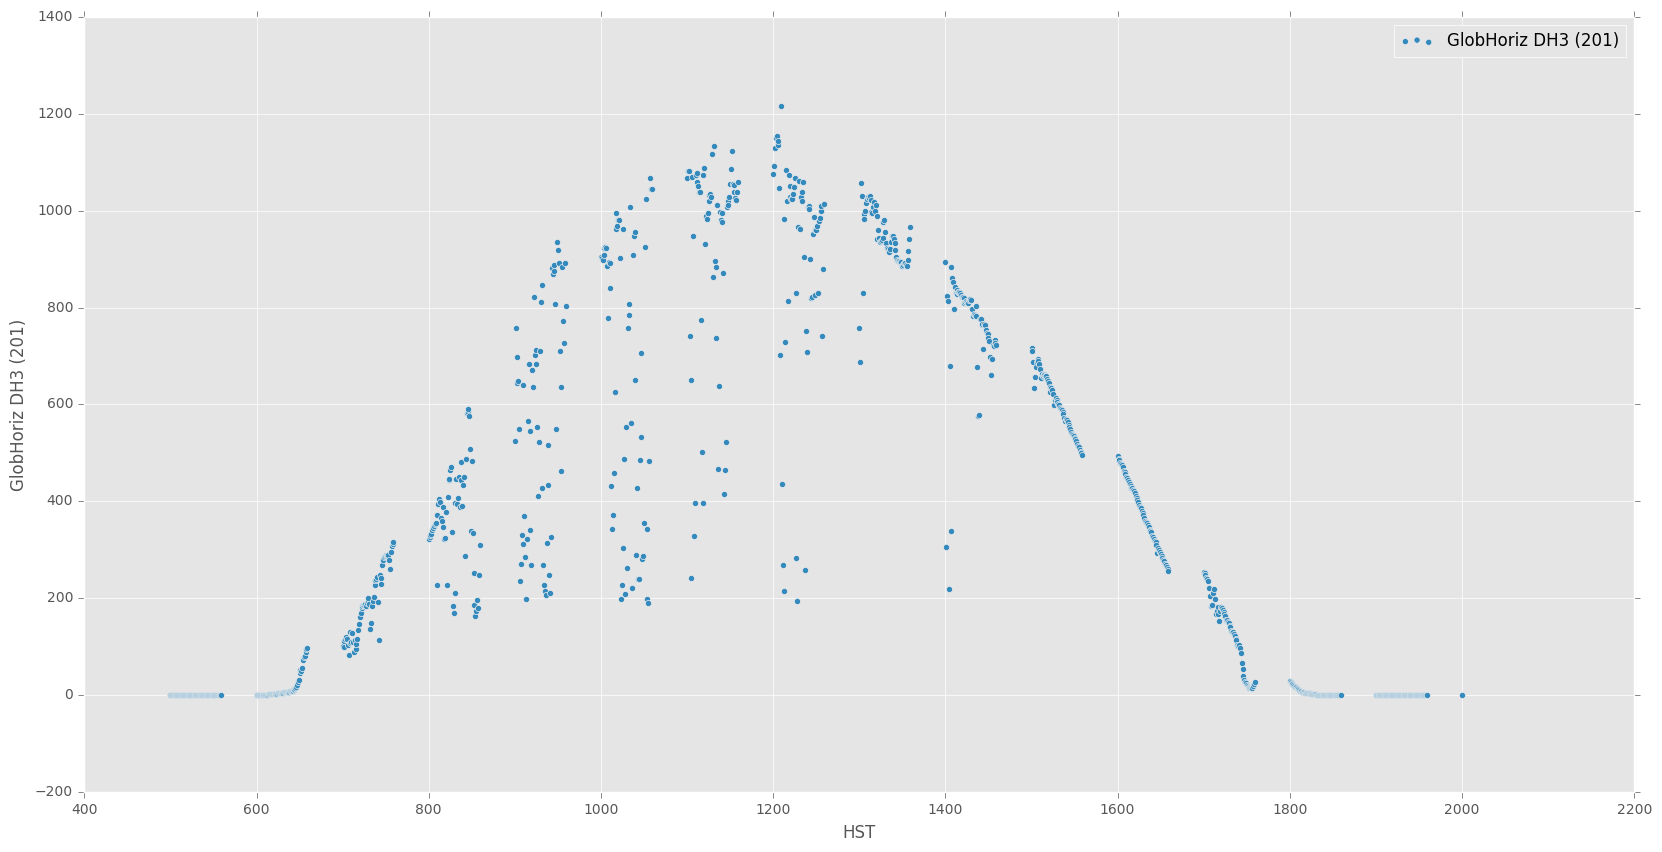

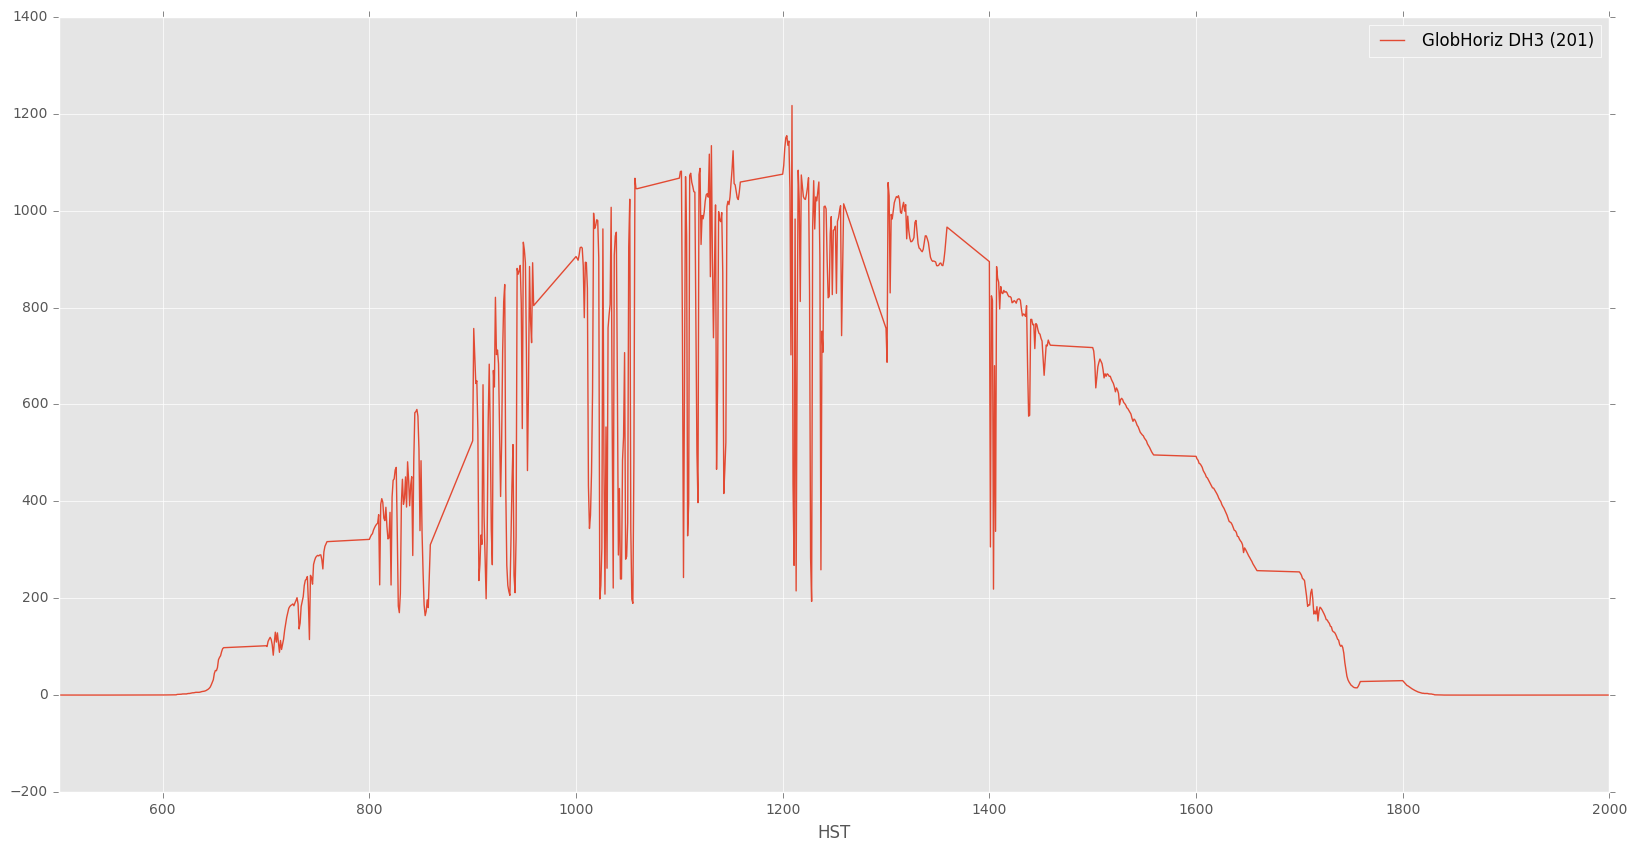

In [10]:
aggr_hst_df.plot(x='HST', y=single_pv, label=single_pv, kind='scatter', figsize = (20,10))
aggr_hst_df.plot(x='HST', y=single_pv, label=single_pv, kind='line', figsize = (20,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009171B00>]], dtype=object)

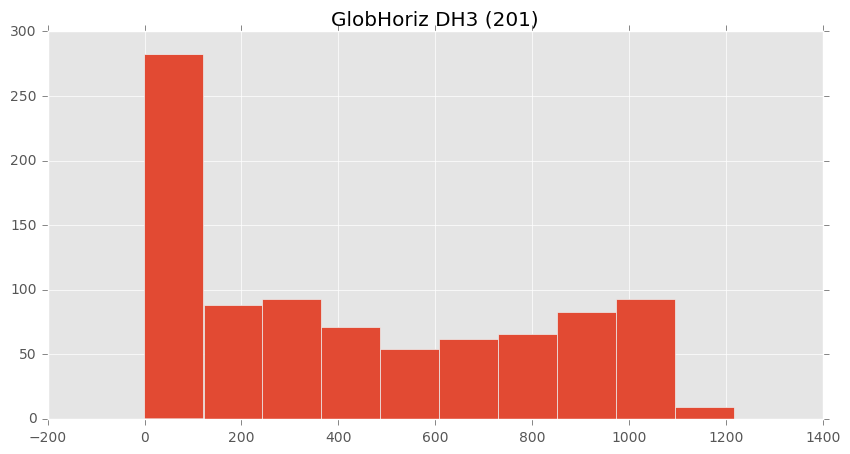

In [11]:
#plot(x='HST', y=, label=single_pv, kind='barh', figsize = (20,10) , normalized=1)

aggr_hst_df[[single_pv]].hist(bins=10, figsize = (10,5))

### Plotting All Panels For A Single Day Grouped By HST

In [12]:
# in a loop

# for value in target_cols:
#     aggr_hst_df.plot(x='HST', y=value, label=value, kind='line', figsize = (20,10))

In [13]:
# at once 

# aggr_hst_df.plot(x='HST', y=target_cols, label=target_cols, subplots = True, figsize = (20, 5*len(target_cols)))

In [14]:
def plot_with_exclude_panels(aggregated_df, panels_to_exclude, also_subploted=False):
    """ Plotting only desired panels, which allows to exclude "non valid" panels. """
 
    panels_to_plot = []
    
    for panel in target_cols:
        if panel not in panels_to_exclude:
            #print (panel)
            panels_to_plot.append(panel)
            
    print ('Ignoring: {0}'.format(' '.join(panels_to_exclude)))
    
    # uncomment in order to get charts one by one
    if also_subploted:
        aggregated_df.plot(x='HST', y=panels_to_plot, label=panels_to_plot, subplots = True, figsize = (20, 5*len(panels_to_plot)))
    
    aggregated_df.plot(x='HST', y=panels_to_plot, label=panels_to_plot, subplots = False, figsize = (20, 15))

Ignoring: GlobHoriz AP3 (211)


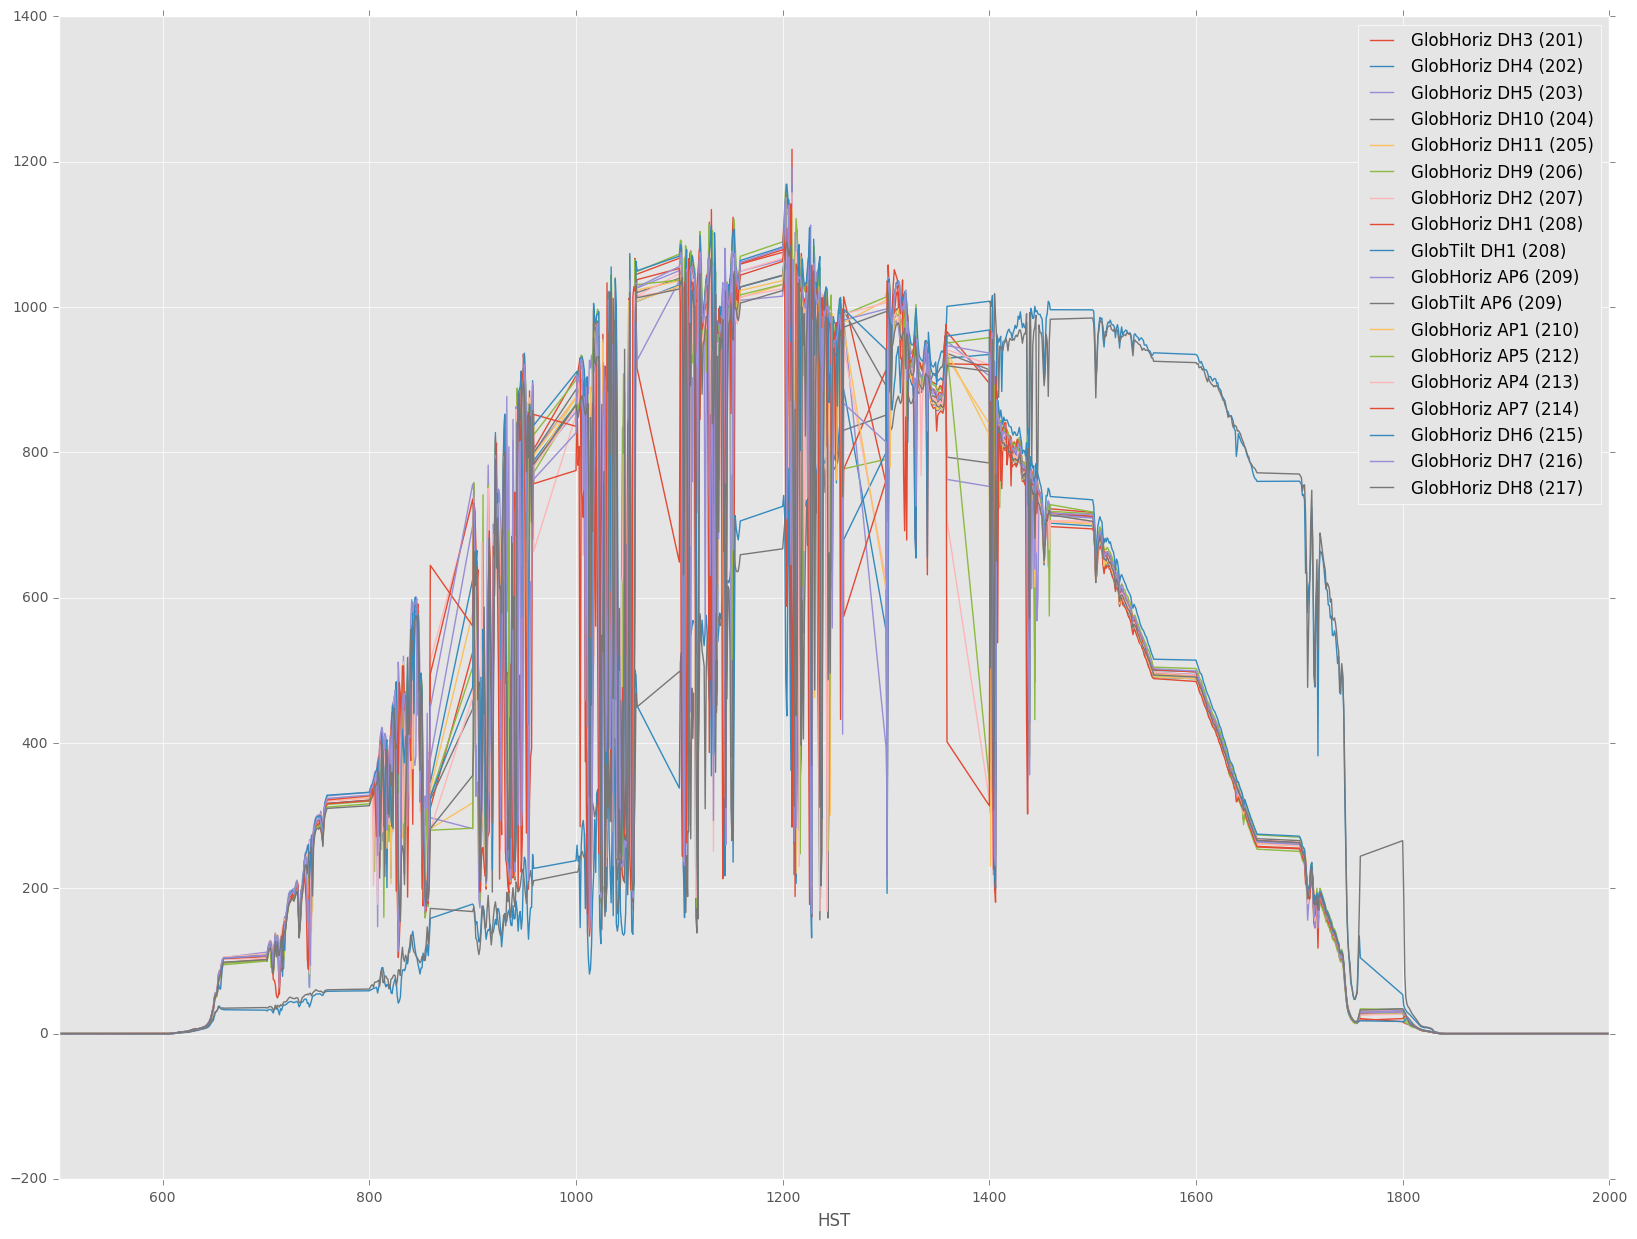

In [15]:
# excluding panel with error measurements

plot_with_exclude_panels(aggr_hst_df, panels_to_exclude = ['GlobHoriz AP3 (211)'])

Ignoring: GlobHoriz AP3 (211) GlobTilt DH1 (208) GlobTilt AP6 (209)


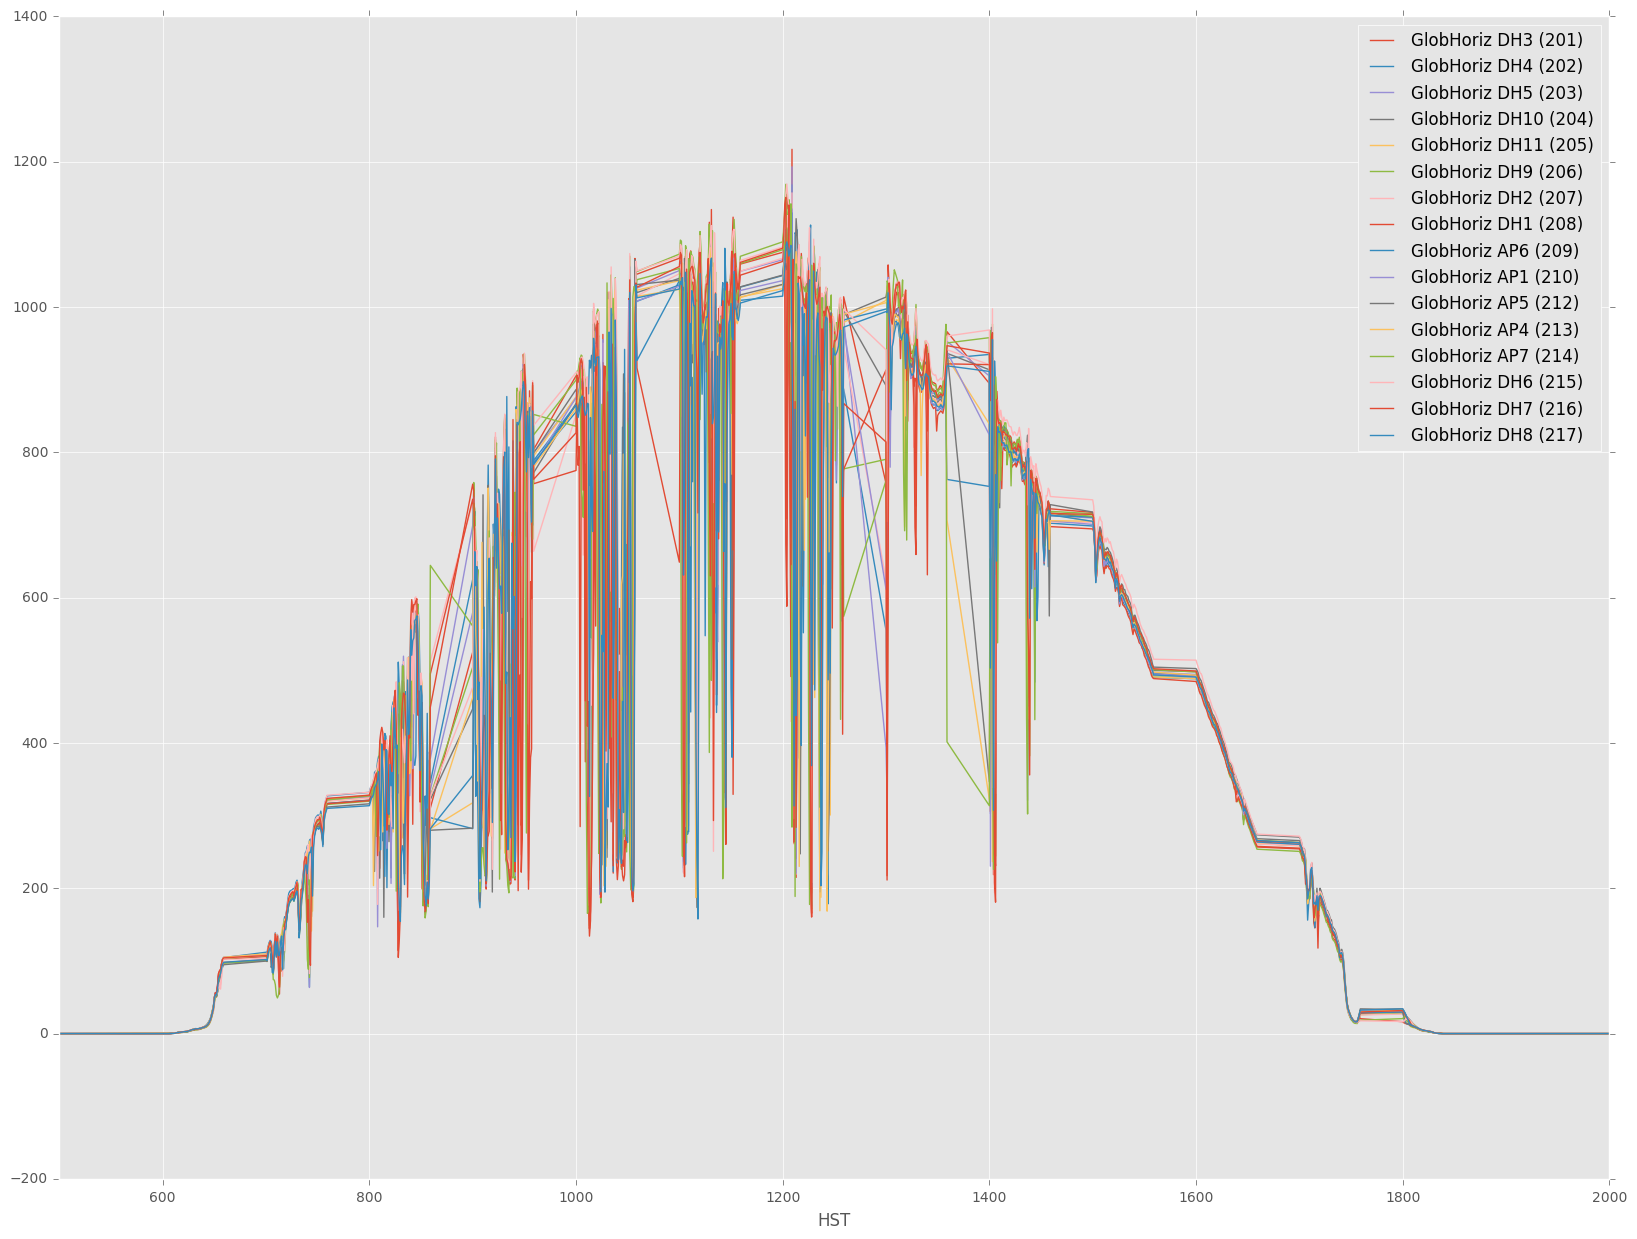

In [16]:
# excluding panel with error measurements and "slow" starters - "Tilt"

plot_with_exclude_panels(aggr_hst_df, panels_to_exclude = ['GlobHoriz AP3 (211)', 'GlobTilt DH1 (208)', 'GlobTilt AP6 (209)'])

## Load and View Data for a Single MONTH (single panel)

In [17]:
SINGLE_MONTH = '{0}\{1}'.format(DATA_FOLDER, '201110')    # single month

# reading data from multiple txt files
csv_files = glob.glob(os.path.join(SINGLE_MONTH, "*.txt")) 
df_from_each_file = (pd.read_csv(f, header=None, sep=',') for f in csv_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=False)
dataset_m = concatenated_df

# set column names from settings
dataset_m.columns = columns

dataset_m.head(5)

Seconds  Year  DOY  HST  GlobHoriz DH3 (201)  GlobHoriz DH4 (202)  \
0        0  2011  274  500             0.000000                  0.0   
1        1  2011  274  500            -0.472098                  0.0   
2        2  2011  274  500            -0.472098                  0.0   
3        3  2011  274  500             0.000000                  0.0   
4        4  2011  274  500             0.000000                  0.0   

   GlobHoriz DH5 (203)  GlobHoriz DH10 (204)  GlobHoriz DH11 (205)  \
0                  0.0                   0.0              0.000000   
1                  0.0                   0.0             -0.385972   
2                  0.0                   0.0              0.000000   
3                  0.0                   0.0              0.000000   
4                  0.0                   0.0              0.000000   

   GlobHoriz DH9 (206)         ...           GlobHoriz AP6 (209)  \
0                  0.0         ...                           0.0   
1                  0.0         ...                           0.0   
2                  0.0         ...                           0.0   
3                  0.0         ...                           0.0   
4                  0.0         ...                           0.0   

   GlobTilt AP6 (209)  GlobHoriz AP1 (210)  GlobHoriz AP3 (211)  \
0                 0.0                  0.0               -99999   
1                 0.0                  0.0               -99999   
2                 0.0                  0.0               -99999   
3                 0.0                  0.0               -99999   
4                 0.0                  0.0               -99999   

   GlobHoriz AP5 (212)  GlobHoriz AP4 (213)  GlobHoriz AP7 (214)  \
0                  0.0              0.00000                  0.0   
1                  0.0              0.00000                  0.0   
2                  0.0              0.00000                  0.0   
3                  0.0             -0.35854                  0.0   
4                  0.0              0.00000                  0.0   

   GlobHoriz DH6 (215)  GlobHoriz DH7 (216)  GlobHoriz DH8 (217)  
0                  0.0                  0.0                  0.0  
1                  0.0                  0.0                  0.0  
2                  0.0                  0.0                  0.0  
3                  0.0                  0.0                  0.0  
4                  0.0                  0.0                  0.0  

[5 rows x 23 columns]

In [18]:
# data description

dataset_m.describe()

Seconds       Year           DOY           HST  \
count  1.674031e+06  1674031.0  1.674031e+06  1.674031e+06   
mean   2.949945e+01     2011.0  2.890000e+02  1.229514e+03   
std    1.731841e+01        0.0  8.944275e+00  4.324052e+02   
min    0.000000e+00     2011.0  2.740000e+02  5.000000e+02   
25%    1.400000e+01     2011.0  2.810000e+02  8.450000e+02   
50%    2.900000e+01     2011.0  2.890000e+02  1.230000e+03   
75%    4.400000e+01     2011.0  2.970000e+02  1.615000e+03   
max    5.900000e+01     2011.0  3.040000e+02  2.000000e+03   

       GlobHoriz DH3 (201)  GlobHoriz DH4 (202)  GlobHoriz DH5 (203)  \
count         1.674031e+06         1.674031e+06         1.674031e+06   
mean          3.173458e+02         3.155808e+02         3.189414e+02   
std           3.236364e+02         3.157457e+02         3.196612e+02   
min          -4.721610e-01         0.000000e+00         0.000000e+00   
25%           1.132380e+01         1.295490e+01         1.293130e+01   
50%           2.235410e+02         2.281730e+02         2.297400e+02   
75%           5.231810e+02         5.212320e+02         5.270310e+02   
max           1.394070e+03         1.368630e+03         1.392990e+03   

       GlobHoriz DH10 (204)  GlobHoriz DH11 (205)  GlobHoriz DH9 (206)  \
count          1.674031e+06          1.674031e+06         1.674031e+06   
mean           3.188334e+02          3.163325e+02         3.181940e+02   
std            3.180030e+02          3.168928e+02         3.257050e+02   
min           -3.608750e-01         -3.860450e-01        -4.723130e-01   
25%            1.335240e+01          1.235100e+01         1.038040e+01   
50%            2.316050e+02          2.283290e+02         2.207430e+02   
75%            5.261735e+02          5.228600e+02         5.252770e+02   
max            1.356080e+03          1.373080e+03         1.437260e+03   

              ...           GlobHoriz AP6 (209)  GlobTilt AP6 (209)  \
count         ...                  1.674031e+06        1.674031e+06   
mean          ...                  3.254429e+02        2.598346e+02   
std           ...                  3.241665e+02        2.975667e+02   
min           ...                  0.000000e+00        0.000000e+00   
25%           ...                  1.286730e+01        1.310570e+01   
50%           ...                  2.358320e+02        1.356300e+02   
75%           ...                  5.461290e+02        4.091385e+02   
max           ...                  1.421220e+03        1.393760e+03   

       GlobHoriz AP1 (210)  GlobHoriz AP3 (211)  GlobHoriz AP5 (212)  \
count         1.674031e+06            1674031.0         1.674031e+06   
mean         -7.512252e+02             -99999.0         3.210783e+02   
std           1.031417e+04                  0.0         3.215530e+02   
min          -9.999900e+04             -99999.0         0.000000e+00   
25%           1.028010e+01             -99999.0         1.274160e+01   
50%           2.305190e+02             -99999.0         2.322740e+02   
75%           5.249835e+02             -99999.0         5.319950e+02   
max           1.340420e+03             -99999.0         1.424450e+03   

       GlobHoriz AP4 (213)  GlobHoriz AP7 (214)  GlobHoriz DH6 (215)  \
count         1.674031e+06         1.674031e+06         1.674031e+06   
mean          3.191495e+02        -1.712263e+03         3.252943e+02   
std           3.175082e+02         1.415021e+04         3.271661e+02   
min          -3.585710e-01        -9.999900e+04         0.000000e+00   
25%           1.290790e+01         6.622620e+00         1.256940e+01   
50%           2.330510e+02         2.272800e+02         2.332920e+02   
75%           5.304610e+02         5.271560e+02         5.372525e+02   
max           1.346940e+03         1.411700e+03         1.399070e+03   

       GlobHoriz DH7 (216)  GlobHoriz DH8 (217)  
count         1.674031e+06         1.674031e+06  
mean          3.207227e+02         3.111908e+02  
std           3.213542e+02         3.124523e+02  

### Grouping By "HST" and "DOY" Columns

In [19]:
aggr_hst_doy_df_m = dataset_m.groupby(['DOY', 'HST']).aggregate(np.mean)
aggr_hst_doy_df_m = aggr_hst_doy_df_m.reset_index()
aggr_hst_doy_df_m[target_cols].describe()

GlobHoriz DH3 (201)  GlobHoriz DH4 (202)  GlobHoriz DH5 (203)  \
count         27931.000000         27931.000000         27931.000000   
mean            316.999439           315.236414           318.593269   
std             317.485789           310.023968           313.837698   
min              -0.471971             0.000000             0.000000   
25%              10.789020            12.449670            12.366100   
50%             229.002383           233.456167           235.442833   
75%             529.883367           528.023525           533.264050   
max            1337.663833          1240.765167          1271.737833   

       GlobHoriz DH10 (204)  GlobHoriz DH11 (205)  GlobHoriz DH9 (206)  \
count          27931.000000          27931.000000         27931.000000   
mean             318.485440            315.987279           317.846651   
std              312.384071            311.334649           319.688640   
min               -0.096231             -0.385951            -0.472147   
25%               12.877582             12.173410             9.955069   
50%              238.268367            235.146200           226.740283   
75%              531.724900            527.658075           532.967008   
max             1287.220333           1284.521667          1299.752983   

       GlobHoriz DH2 (207)  GlobHoriz DH1 (208)  GlobTilt DH1 (208)  \
count         27931.000000         27931.000000        27931.000000   
mean            315.448684           313.900795          257.768294   
std             310.940419           308.193243          300.550405   
min               0.000000             0.000000            0.000000   
25%              12.024678            11.970378           11.463212   
50%             232.753567           233.695900          123.797150   
75%             528.700600           527.483767          411.239150   
max            1243.316167          1267.794267         1190.585333   

       GlobHoriz AP6 (209)  GlobTilt AP6 (209)  GlobHoriz AP1 (210)  \
count         27931.000000        27931.000000         27931.000000   
mean            325.087676          259.551064          -753.925827   
std             318.425029          293.653127         10322.783938   
min               0.000000            0.000000        -99999.000000   
25%              12.404787           12.745644             9.938270   
50%             240.372217          136.023667           236.720483   
75%             552.091775          420.891425           531.319233   
max            1290.410767         1196.649667          1269.445167   

       GlobHoriz AP3 (211)  GlobHoriz AP5 (212)  GlobHoriz AP4 (213)  \
count              27931.0         27931.000000         27931.000000   
mean              -99999.0           320.727895           318.800875   
std                    0.0           315.707991           311.704249   
min               -99999.0             0.000000            -0.358540   
25%               -99999.0            12.452688            12.723317   
50%               -99999.0           238.311933           238.904417   
75%               -99999.0           539.168475           536.094925   
max               -99999.0          1256.950667          1261.534500   

       GlobHoriz AP7 (214)  GlobHoriz DH6 (215)  GlobHoriz DH7 (216)  \
count         27931.000000         27931.000000         27931.000000   
mean          -1713.914525           324.939245           320.372665   
std           14152.344672           321.380011           315.680802   
min          -99999.000000             0.000000            -0.050954   
25%               6.508999            12.147143            12.459272   
50%             232.978883           239.100150           236.481017   
75%             534.887400           543.130892           537.515233   
max            1341.287400          1292.587500          1265.752500   

       GlobHoriz DH8 (217)  
count         27931.000000  
mean            310.851013  
std             306.958234

Ignoring: GlobHoriz AP3 (211) GlobHoriz AP7 (214) GlobHoriz AP1 (210) GlobTilt DH1 (208) GlobTilt AP6 (209)


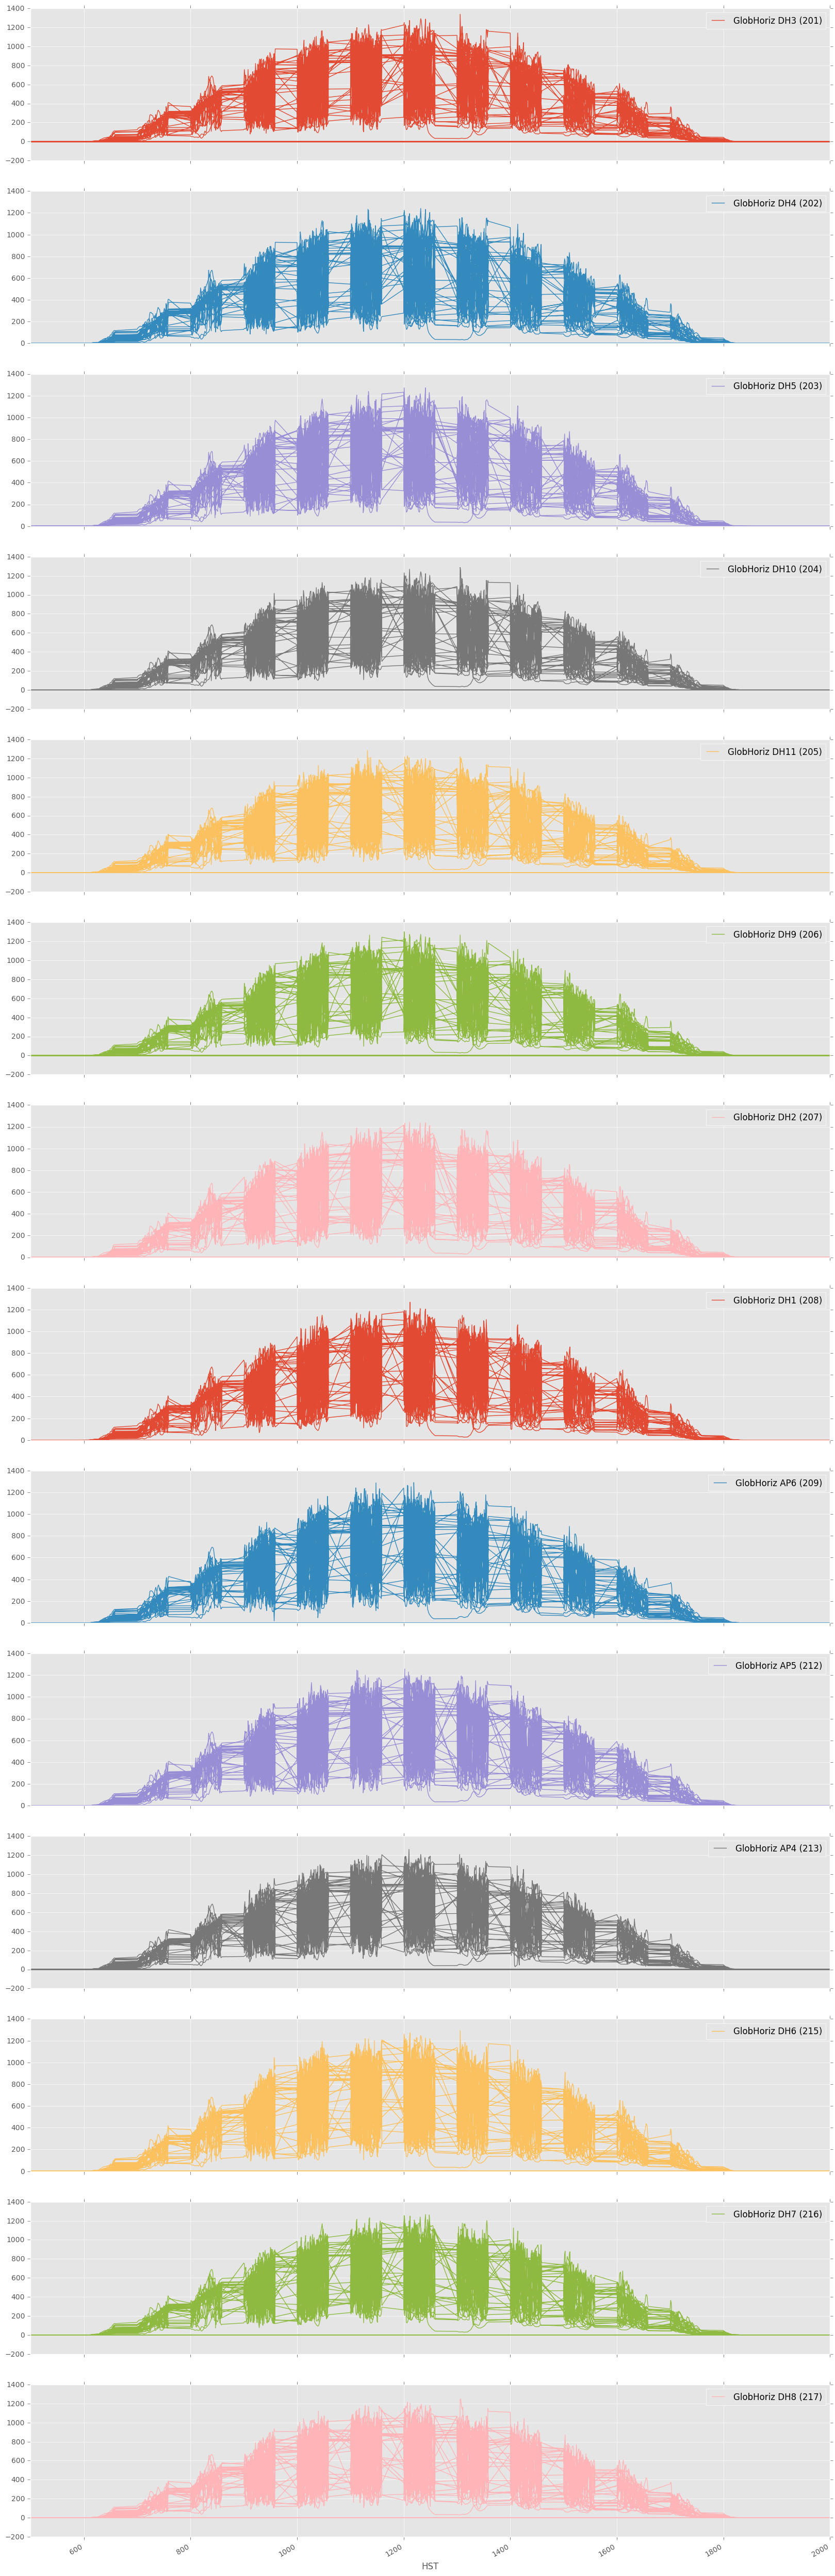

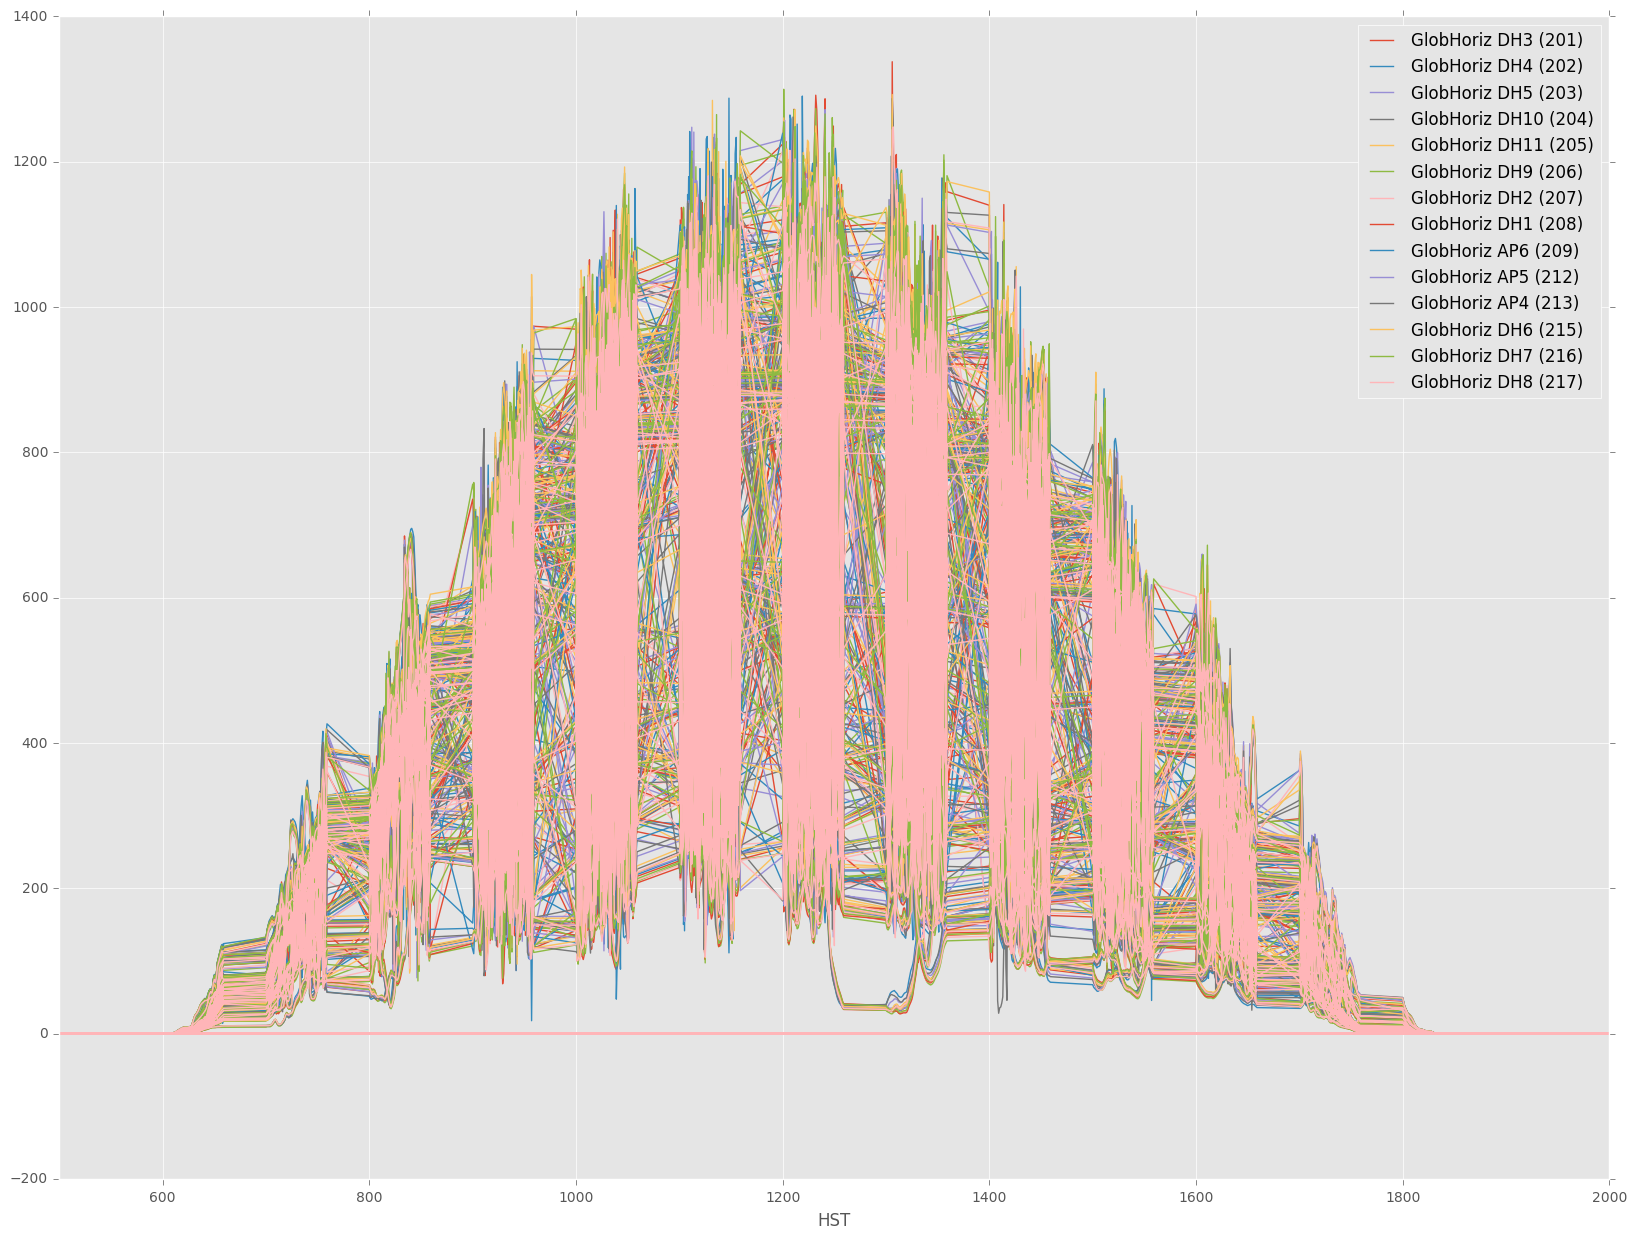

In [20]:
tmp_panels_to_exclude = ['GlobHoriz AP3 (211)', 
                         'GlobHoriz AP7 (214)', 
                         'GlobHoriz AP1 (210)',
                         'GlobTilt DH1 (208)',
                         'GlobTilt AP6 (209)']

plot_with_exclude_panels(aggr_hst_doy_df_m, panels_to_exclude = tmp_panels_to_exclude, also_subploted= True)